In [230]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);

In [303]:
SubChunkSize = 20
function DiffrenceIndex(i)
    return(div(i,SubChunkSize,RoundUp))
end
function SubXDif(xs,i)
    return(xs[i] - xs[div(i-1,SubChunkSize,RoundDown)*SubChunkSize+1])
end



@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, we get some numbers and functions needed for the rest of the analysis
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)

    # Next, we generate some parameters of the model. There are three types of randomly made perameters. First are the constant ones
    #That are unique to the process. These are generated first.
    #Second are the ones that are unique to the individual chunks. These loop from 1 to NumChunks
    #Last are the ones that vary for every point. These range from 1 to n


    #Unique to process
#
    #Where the series starts. In the log model this is around 12 and I give it a pretty big window
    Buffer_y ~ normal(1000, 10000) 
    Buffer_SubSlope ~ normal(0, 300) 

    #the probability any given point is a outlier
    prob_outlier ~ uniform(.01, .05)
    #The scaling factor on outliers:
    OutlierDeg ~ uniform(2, 10)
    
    #unique to chunk

    #The data apears to have no slope over 3 so a sd of 2 should capture the true slopes with high probability
    Slopes = [{(:slope, i)} ~ normal(0, 300) for i=1:NumChunks]

    #The SubSlope is defined by the previous slopes and the initial subslope
    SubSlope = cumsum(pushfirst!([SubChunkSize*Slopes[i] for i=1:NumChunks],Buffer_SubSlope))


    #The distribution of the noise. It gets fed into the sd of a normal distribution so the distribution of the noise needs to be always positive
    noise = [{(:noise, i)} ~ gamma(200, 200) for i=1:NumChunks]




    #EveryPoint

    #is using the prob_outlier vector above to decide if each point is an outlier. the model we are using now has 
    #The slope and sd $OutlierDeg times larger then the non outliers. so we times the mu and sd by this value in the last step
    PointOutlier = ((OutlierDeg-1)*[{:data => i => :is_outlier} ~ bernoulli(prob_outlier) for i=1:n] .+ 1)

    #calculates the change of y from the previous chunk to the current x. We combine this with a set of y ofset values
    #in the next step to get the true mu fed into the normal distribution
    #TrueDeltaMu n = Slope[chunk](x[i]- x[Last chunk])
    TrueDeltaMu = [Slopes[DiffrenceIndex(i)]*SubXDif(xs,i)^2 + SubSlope[DiffrenceIndex(i)]*SubXDif(xs,i) for i=1:n]


    #calculating the 'y intercept' of each chunk to make sure each line connects to the last one
    #Because each intercept gets added to the last one we take the cumalitive sum to get the total ofset needed at each step
    #The first value should be the initial ofset Buffer_y to get everything aligned
    #ysOfseted = [Buffer_y, Slope[chunk](x[chunk]- x[Last chunk])]
    ysOfseted = cumsum(pushfirst!([TrueDeltaMu[(i)*SubChunkSize] - TrueDeltaMu[(i-1)*SubChunkSize+1] for i=1:(NumChunks-1)],Buffer_y))


    #The random var fit to the actual data. It is created as a combination of previous parts
    #The process was discribed in previous steps
    #ys = normal(mu, sd)
    #mu = (2*isoutlier + 1)yvalue[i] + ysOfseted[current chunk]
    #sd = (2*isoutlier + 1)noise[i]
    ys = [{:data => i => :y} ~ normal((TrueDeltaMu[i] + ysOfseted[DiffrenceIndex(i)])*PointOutlier[i], noise[DiffrenceIndex(i)]) for i=1:n]
    ys
end;

In [305]:
using Plots
#length(floor(xs/40)+1)
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    Dict(:slope => [trace[(:slope, i)] for i in 1:NumChunks],
         #:SubSlope => [trace[(:SubSlope, i)] for i in 1:NumChunks],
         :inlier_std => [trace[(:noise, i)] for i in 1:NumChunks],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :Buffer_y => trace[:Buffer_y],
         :Buffer_SubSlope => trace[:Buffer_SubSlope],
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

In [306]:
#ysOfseted
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    n = length(trace[:xs])
    NumChunks = div(n, SubChunkSize, RoundUp)


    #Graph points
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    PLT = Plots.scatter(0,0)
    PLT = Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing, title=title) 
    PLT = Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)
    

    #GraphLine

    SubSlopes = cumsum(pushfirst!([SubChunkSize*trace[:slope][i] for i=1:NumChunks],trace[:Buffer_SubSlope]))
    XFunc(n)=(trace[:slope][DiffrenceIndex(n)]) * SubXDif(trace[:xs],n)^2 +
             (SubSlopes[DiffrenceIndex(n)]) * SubXDif(trace[:xs],n)

    
    yInter = cumsum(
        pushfirst!(
            [XFunc(i*SubChunkSize) - XFunc((i-1)*SubChunkSize+1) for i=1:(NumChunks-1)],
            trace[:Buffer_y])
            )
    
    LeftX = trace[:xs][1]
    LeftY = yInter[1]
    for i = 2:n
        RightX =  trace[:xs][i]
        RightY = XFunc(i) + yInter[DiffrenceIndex(i)]
        PLT = Plots.plot!([LeftX, RightX], [LeftY, RightY], color = "black", lw = 3, label = nothing)
        LeftX = RightX
        LeftY = RightY
    end
    return PLT
end
#, xlims=[MinX, MaxX], ylims=[MinY, MaxY]

visualize_trace (generic function with 1 method)

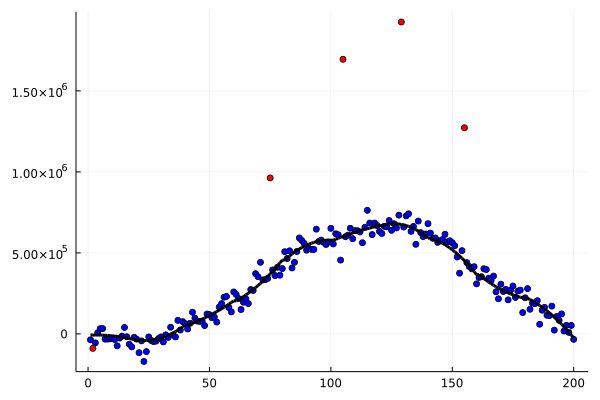

In [317]:
ts     = collect(range(1, stop=200, length=200))
traces = Gen.simulate(regression_with_outliers, (ts,));
Plots.plot(visualize_trace(traces))

In [137]:
dataframe = CSV.read("../Data/Proccesed/DetrendedCov.csv", DataFrame)

,Column1,Date,N1,LoessN1,DetrendedN1
,Int64,Int64,Int64,Float64,Float64
1,1,0,63618,-3628.0,67246.0
2,2,4,11442,12206.4,-764.409
3,3,7,39145,24029.8,15115.2
4,4,10,28553,35819.2,-7266.18
5,5,9,16743,31895.1,-15152.1
6,6,8,30509,27971.0,2538.04
7,7,13,22794,47527.4,-24733.4
8,8,14,25014,51430.1,-26416.1
9,9,17,38687,63050.0,-24363.0


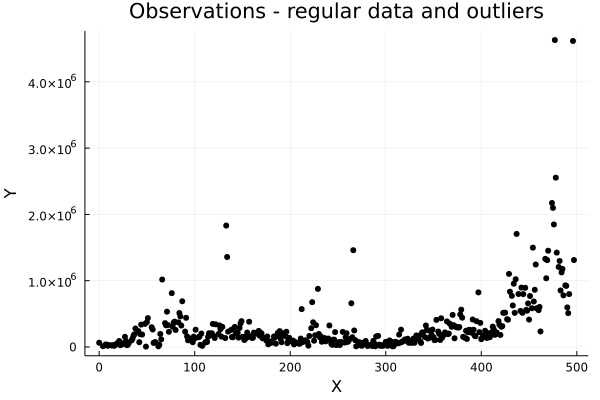

In [323]:
#using DataArrays
dataframe[!,:N1] = convert.(Base.Float64,dataframe[!,:N1])
dataframe[!,:Date] = convert.(Base.Float64,dataframe[!,:Date])
#390
xs = dataframe."Date"[1:390]
ys = dataframe."N1"[1:390]

Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

In [294]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [295]:
observations = make_constraints(ys);

In [296]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [11]:
#traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 1000)) for i in 1:9]
#log_probs = [get_score(t) for t in traces]
#println("Average log probability: $(logmeanexp(log_probs))")
#Plots.plot([visualize_trace(t) for t in traces]...)

In [320]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    (xs,) = get_args(tr)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)

    for j=1:(NumChunks)
        # Block 1: Update the line's parameters
        line_params = select((:noise,j-2), (:slope,j-2),
                    :noise,j-1), (:slope,j-1),
                    (:noise,j), (:slope,j),
                    (:noise,j+1), (:slope,j+1),
                    (:noise,j+1), (:slope,j+2))
        (tr, _) = mh(tr, line_params)
    end
    
    # Blocks 2-N+1: Update the outlier classifications
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier,:OutlierDeg))
    
    # Return the updated trace
    tr
end;

In [321]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_PqeqERVPcE.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\tXtrW\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_PqeqERVPcE.gif")
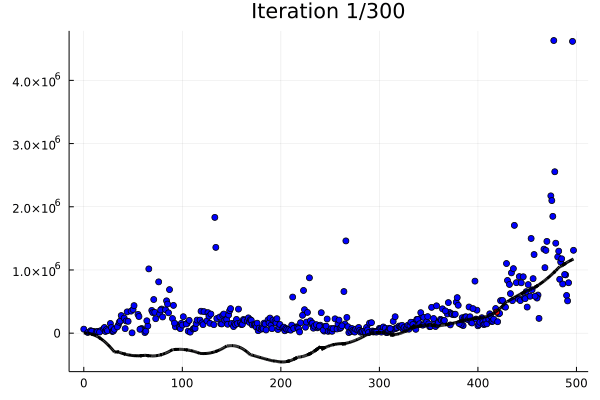

In [324]:
t, = generate(regression_with_outliers, (xs,), observations)
Iter = 300
viz = Plots.@animate for i in 1:Iter
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/$Iter")
end;
gif(viz)